# Analyse ROMY Events

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sixdegrees.sixdegrees import sixdegrees

from sixdegrees.plots.plot_velocities import plot_velocities
from sixdegrees.plots.plot_trace_dispersion import plot_trace_dispersion

## Configurations

Here we load the data from a local mseed file (data_source = "mseed_file"). All parameters for the processing and plotting are set hereafter in the configuration dictionary.

In [2]:
config = {
    # Required time window parameters
    'tbeg': "2023-09-08 22:13:00",  # Start time
    'tend': "2023-09-08 23:00:00",  # End time

    # event
    'origin_time': "2023-09-08 22:11:00",
    'magnitude': 6.8,

    # Station coordinates (required)
    'station_lon': 11.275476,  # BSPF longitude
    'station_lat': 48.162941,    # BSPF latitude
    
    # SEED identifiers
    'seed': "XX.ROMY..",     # Default seed ID
    'rot_seed': ["XX.ROMY..BJZ", "XX.ROMY..BJN", "XX.ROMY..BJE"], # "BW.ROMY.30.BJ*",  # Rotation sensor seed ID
    'tra_seed': ["XX.ROMY..BHZ", "XX.ROMY..BHN", "XX.ROMY..BHE"],  # Translation sensor seed ID
    
    # Data source
    'data_source': "mseed_file",  # "fdsn" | "sds" | "mseed_file"

    # Path to local mseed file
    'path_to_mseed_file': "./data/romy_eventM6.8.mseed",  # "./data/eventM62_6c.mseed",

    # Path configurations
    'workdir': "./",            # Working directory
    'path_to_data_out': "./output/",  # Output directory

    # Project information
    'project': "ROMY_Analysis",  # Project name
    
    # Backazimuth calculation parameters
    'baz_step': 1,               # Step size for backazimuth search in degrees
    'twin_sec': 100,          # Window length in seconds
    'twin_overlap': 0.5,  # Window overlap in seconds
    'cc_threshold': 0.0,        # Cross-correlation threshold

    # Filter parameters
    'fmin': 0.02,               # Minimum frequency for filtering
    'fmax': 0.2,                # Maximum frequency for filtering
    
    # Optional parameters
    'verbose': True,            # Print detailed information
}

Setup a sixdegrees object

In [3]:
sd = sixdegrees(conf=config)

Store the configuration as a pickle file

In [4]:
# sd.store_as_pickle(config, "./event_configs/"+f"M{str(config['magnitude']).replace('.','')}_{config['tbeg'][:10].replace('-','')}")

Get key information about the event

In [5]:
ev = sd.get_event_info(
    origin_time=config['origin_time'],
    base_catalog="USGS",
    magnitude=config['magnitude']
)

Found event:
Origin time: 2023-09-08T22:11:01.405000Z
Magnitude: 6.8 mww
Location: 31.058°N, -8.385°E
Depth: 19.0 km
Epicentral Distance: 2526.01 km
Epicentral Distance: 22.7°
Backazimuth: 228.40°


This will load the data from the data source:
- local mseed file
- local sds system
- fdsn (online)

and trim it to the time window

In [6]:
sd.load_data(config['tbeg'], config['tend'])

-> fetching XX.ROMY..BHZ data from mseed file
-> fetching XX.ROMY..BHN data from mseed file
-> fetching XX.ROMY..BHE data from mseed file
3 Trace(s) in Stream:
XX.ROMY..BHZ | 2023-09-08T22:12:58.989999Z - 2023-09-08T23:00:00.989999Z | 20.0 Hz, 56441 samples
XX.ROMY..BHN | 2023-09-08T22:12:58.990000Z - 2023-09-08T23:00:00.990000Z | 20.0 Hz, 56441 samples
XX.ROMY..BHE | 2023-09-08T22:12:58.990000Z - 2023-09-08T23:00:00.990000Z | 20.0 Hz, 56441 samples
-> fetching XX.ROMY..BJZ data from mseed file
-> fetching XX.ROMY..BJN data from mseed file
-> fetching XX.ROMY..BJE data from mseed file
3 Trace(s) in Stream:
XX.ROMY..BJZ | 2023-09-08T22:12:59.011600Z - 2023-09-08T23:00:01.011600Z | 20.0 Hz, 56441 samples
XX.ROMY..BJN | 2023-09-08T22:12:58.999400Z - 2023-09-08T23:00:00.999400Z | 20.0 Hz, 56441 samples
XX.ROMY..BJE | 2023-09-08T22:12:59.036600Z - 2023-09-08T23:00:00.986600Z | 20.0 Hz, 56440 samples


Ensure that all traces of stream have the same sample size

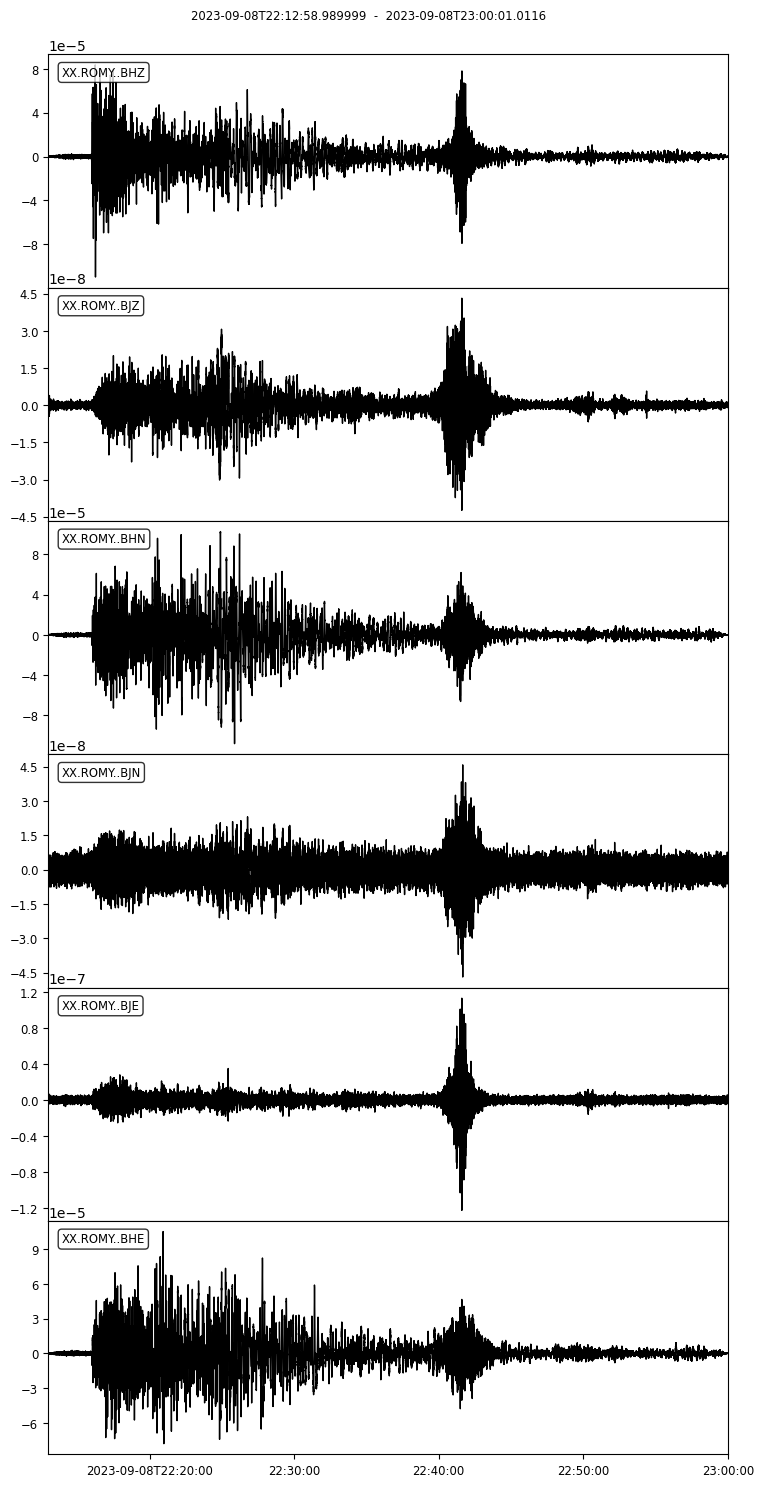

In [7]:
sd.st.plot(equal_scale=False);

In [8]:
sd.trim_stream(set_common=True, set_interpolate=False)

 -> stream size inconsistent: [56441, 56441, 56441, 56441, 56441, 56440]
  -> adjusted: [56440, 56440, 56440, 56440, 56440, 56440]


## Analysis

Frequency band to filter (this is applied to the stream object after being reset to raw stream)

In [9]:
sd.filter_data(fmin=config['fmin'], fmax=config['fmax'], output=False)

Apply polarity correction if needed. This is applied to the stream object that is processed. If raw is True, the polarity correction is applied to the raw stream too.

In [10]:
sd.polarity_stream(pol_dict={"HZ": -1, "JZ": 1}, raw=True)

-> polarity for channel HZ changed from 1 to -1


### Analyse phase velocities

In [11]:
# Compute Love wave velocities
love_velocities = sd.compute_velocities(
    wave_type='love',
    win_time_s=config['twin_sec'],
    overlap=0.5,
    cc_threshold=config['cc_threshold'],
    method='odr',  # 'odr' | 'ransac'
    baz=ev['backazimuth']  # theoretical backazimuth (optional)
)

# Compute Rayleigh wave velocities
rayleigh_velocities = sd.compute_velocities(
    wave_type='rayleigh',
    win_time_s=config['twin_sec'],
    overlap=0.5,
    cc_threshold=config['cc_threshold'],
    method='odr',  # 'odr' | 'ransac'
    baz=ev['backazimuth']  # theoretical backazimuth (optional)
)

In [ ]:
# Plot results
fig = plot_velocities(
    sd,
    velocity_results=love_velocities,
    vmax=5000,  # optional
    minors=True, # optional
    figsize=(15, 7)
)

# Plot results
fig = plot_velocities(
    sd,
    velocity_results=rayleigh_velocities,
    vmax=5000,  # optional
    minors=True, # optional
    figsize=(15, 7)
)


### Check velocities in time windows

Estimating backazimuth and velocities in time windows rather than assuming the backazimuth is constant.


In [ ]:
baz_results_love = sd.compute_backazimuth(
    wave_type='love',
    baz_step=config['baz_step'],
    baz_win_sec=config['twin_sec'],
    baz_win_overlap=config['twin_overlap'],
    cc_threshold=config['cc_threshold'],
    out=True  # Return results dictionary
)

baz_results_rayleigh = sd.compute_backazimuth(
    wave_type='rayleigh',
    baz_step=config['baz_step'],
    baz_win_sec=config['twin_sec'],
    baz_win_overlap=config['twin_overlap'],
    cc_threshold=config['cc_threshold'],
    out=True  # Return results dictionary
)

In [ ]:

love_velocities_win1 = sd.compute_velocities_optimized(
    wave_type='love',
    baz_results=baz_results_love,
    baz_mode='mid',  # 'mid' or 'max' - use 'mid' for median backazimuth, 'max' for maximum correlation
    method='odr',  # 'odr' | 'ransac' | 'theilsen'
    cc_threshold=config['cc_threshold'],
    r_squared_threshold=0.5,  # Minimum R-squared threshold for regression quality
    zero_intercept=True,  # Force intercept to be zero
    plot=False  # Set to True to plot regression results
)


rayleigh_velocities_win1 = sd.compute_velocities_optimized(
    wave_type='rayleigh',
    baz_results=baz_results_rayleigh,
    baz_mode='mid',  # 'mid' or 'max' - use 'mid' for median backazimuth, 'max' for maximum correlation
    method='odr',  # 'odr' | 'ransac' | 'theilsen'
    cc_threshold=config['cc_threshold'],
    r_squared_threshold=0.5,  # Minimum R-squared threshold for regression quality
    zero_intercept=True,  # Force intercept to be zero
    plot=False  # Set to True to plot regression results
)

In [ ]:
# Plot results
fig = plot_velocities(
    sd,
    velocity_results=love_velocities_win1,
    vmax=5000,  # optional
    minors=True, # optional
    figsize=(15, 7)
)

fig = plot_velocities(
    sd,
    velocity_results=rayleigh_velocities_win1,
    vmax=5000,  # optional
    minors=True, # optional
    figsize=(15, 7)
)

### Compare RANSAC and ODR Regression

Here we compare the RANSAC and ODR Regression methods for the computation of the phase velocities.

In [ ]:
# Compute Love wave velocities
love_velocities_ransac = sd.compute_velocities(
    wave_type='love',
    win_time_s=config['twin_sec'],
    overlap=config['twin_overlap'],
    cc_threshold=config['cc_threshold'],
    method='ransac',  # 'odr' | 'ransac'
    baz=ev['backazimuth']  # theoretical backazimuth (optional)
)

# Compute Rayleigh wave velocities
rayleigh_velocities_ransac = sd.compute_velocities(
    wave_type='rayleigh',
    win_time_s=config['twin_sec'],
    overlap=config['twin_overlap'],
    cc_threshold=config['cc_threshold'],
    method='ransac',  # 'odr' | 'ransac'
    baz=ev['backazimuth']  # theoretical backazimuth (optional)
)

# Compute Love wave velocities
love_velocities_odr = sd.compute_velocities(
    wave_type='love',
    win_time_s=config['twin_sec'],
    overlap=config['twin_overlap'],
    cc_threshold=config['cc_threshold'],
    method='odr',  # 'odr' | 'ransac'
    baz=ev['backazimuth']  # theoretical backazimuth (optional)
)

# Compute Rayleigh wave velocities
rayleigh_velocities_odr = sd.compute_velocities(
    wave_type='rayleigh',
    win_time_s=config['twin_sec'],
    overlap=config['twin_overlap'],
    cc_threshold=config['cc_threshold'],
    method='odr',  # 'odr' | 'ransac'
    baz=ev['backazimuth']  # theoretical backazimuth (optional)
)

In [ ]:
fig = sd.plot_velocity_method_comparison(
    rayleigh_velocities_win1,
    rayleigh_velocities_odr,
    cc_threshold=0.0,
    label1='Optimized ODR',
    label2='ODR',
    wave_type='Rayleigh'
)

In [ ]:
def plot_velocity_comparison(ransac_results, odr_results, label1='RANSAC', label2='ODR', wave_type='Rayleigh', vmax=5000):
    """
    Create a scatter plot comparing velocities from RANSAC and ODR methods.
    
    Parameters:
    -----------
    ransac_results : dict
        Results dictionary from compute_velocities with method='ransac'
    odr_results : dict
        Results dictionary from compute_velocities with method='odr'
    wave_type : str
        Type of wave ('Rayleigh' or 'Love') for the plot title
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object containing the plot
    """
    # Extract velocities
    ransac_vel = ransac_results['velocity']
    odr_vel = odr_results['velocity']
    
    # Create figure
    fig, ax = plt.subplots(figsize=(7, 7))
    
    # Create scatter plot
    sc = ax.scatter(ransac_vel, odr_vel, 
                   c=ransac_results['ccoef'], cmap='viridis', 
                   alpha=0.7, s=50, edgecolor='k', linewidth=0.5, vmin=0.0, vmax=1.0)
    
    # Add colorbar
    cax = ax.inset_axes([1.02, 0.0, 0.05, 1.0])
    cbar = plt.colorbar(sc, cax=cax)
    cbar.set_label('Cross-Correlation Coefficient')
    
    # Add identity line
    vals = np.linspace(0, 10_000, 100)
    ax.plot(vals, vals, 'r--', label='1:1 Line')
    
    ax.set_xlim(0, vmax)
    ax.set_ylim(0, vmax)

    # Add labels and title
    ax.set_xlabel(f'{label1} Velocity (m/s)')
    ax.set_ylabel(f'{label2} Velocity (m/s)')
    ax.set_title(f'{wave_type} Wave Velocity: {label1} vs {label2} Comparison')
    
    # Add grid and legend
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Set equal aspect ratio
    ax.set_aspect('equal')
    
    # Add statistics
    diff = np.array(odr_vel) - np.array(ransac_vel)
    mean_diff = np.nanmean(diff)
    std_diff = np.nanstd(diff)
    
    stats_text = f"Mean difference ({label2}-{label1}): {mean_diff:.2f} m/s\n"
    stats_text += f"Standard deviation: {std_diff:.2f} m/s"
    
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    return fig

In [ ]:
# Rayleigh
fig = plot_velocity_comparison(rayleigh_velocities_ransac, rayleigh_velocities_odr, label1='RANSAC', label2='ODR', wave_type='Rayleigh')
# Love
fig = plot_velocity_comparison(love_velocities_ransac, love_velocities_odr, label1='RANSAC', label2='ODR', wave_type='Love')


In [ ]:
# Rayleigh
fig = plot_velocity_comparison(rayleigh_velocities_win1, rayleigh_velocities_odr, label1='Optimized ODR', label2='ODR', wave_type='Rayleigh')
# Love
fig = plot_velocity_comparison(love_velocities_win1, love_velocities_odr, label1='Optimized ODR', label2='ODR', wave_type='Love')


### Dispersion Curves

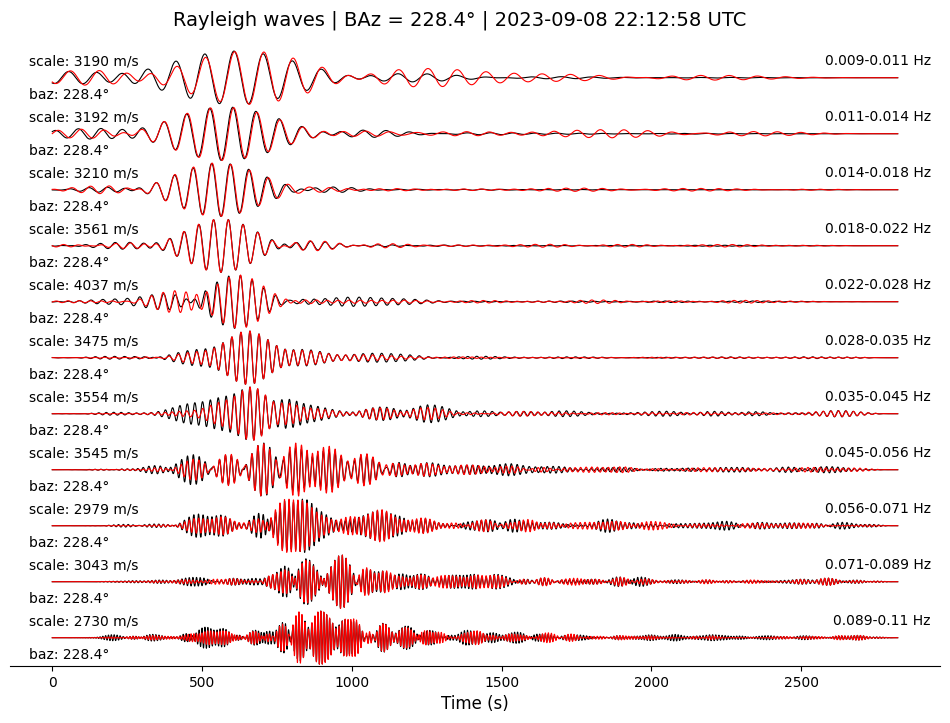

In [12]:
fig, disp_rayleigh = plot_trace_dispersion(
    sd_object=sd,
    wave_type="rayleigh",
    fmin=0.01,
    fmax=0.1,
    fraction_of_octave=3,
    baz=ev['backazimuth'],
    figsize=(12, 8),
    optimized=False,
    output=True
)

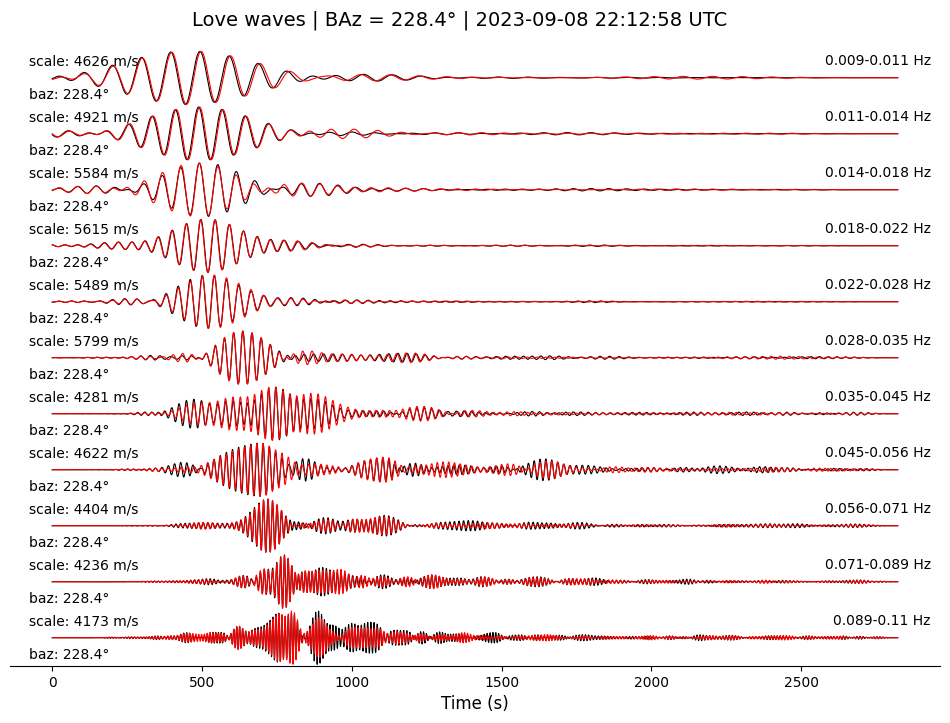

In [13]:
fig, disp_love = plot_trace_dispersion(
    sd_object=sd,
    wave_type="Love",
    fmin=0.01,
    fmax=0.1,
    fraction_of_octave=3,
    baz=ev['backazimuth'],
    figsize=(12, 8),
    optimized=False,
    output=True
)


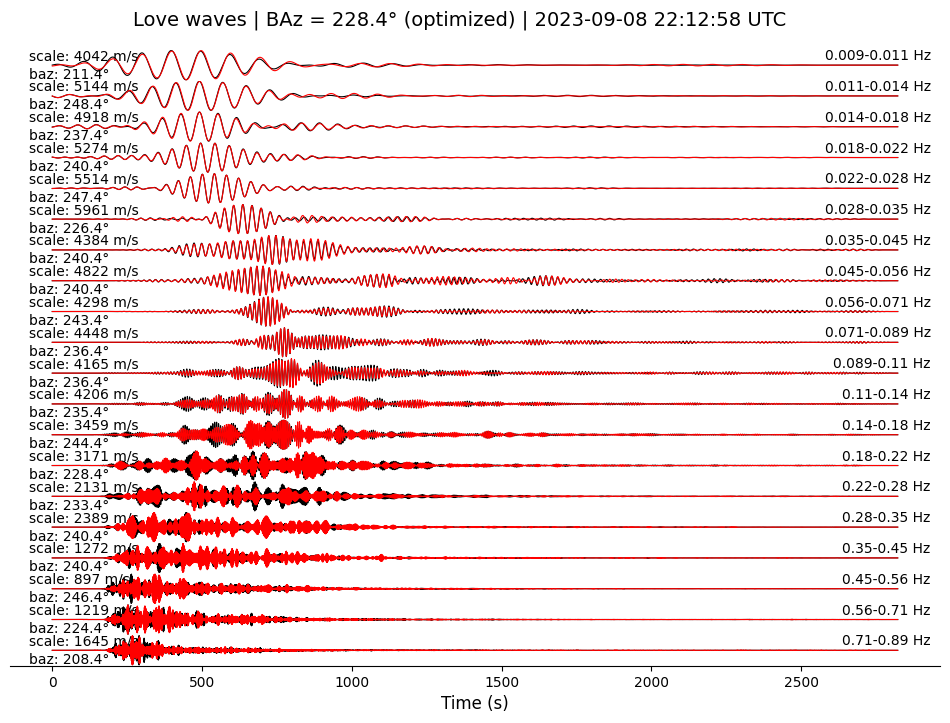

In [14]:
fig, disp_love_opt = plot_trace_dispersion(
    sd_object=sd,
    wave_type="Love",
    fmin=0.01,
    fmax=0.8,
    fraction_of_octave=3,
    baz=ev['backazimuth'],
    figsize=(12, 8),
    optimized=True,
    output=True
)


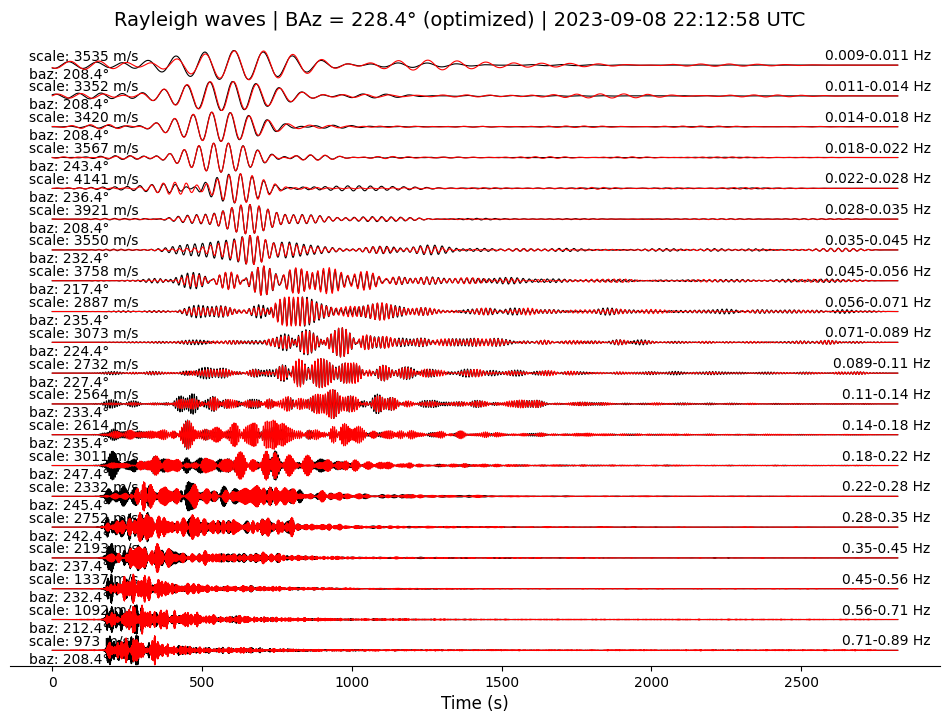

In [15]:
fig, disp_rayleigh_opt = plot_trace_dispersion(
    sd_object=sd,
    wave_type="Rayleigh",
    fmin=0.01,
    fmax=0.8,
    fraction_of_octave=3,
    baz=ev['backazimuth'],
    figsize=(12, 8),
    optimized=True,
    output=True
)

In [17]:
def plot_dispersion(
        dispersion_data,
        plot_type = "velocity",
        figsize = None,
        title = None,
        wave_type = None
    ) -> plt.Figure:
    """
    Plot dispersion curves for velocity or backazimuth from plot_filtered_traces_frequency_bands output.
    
    Creates a single figure based on plot_type:
    - "velocity": Phase velocity vs frequency
    - "backazimuth": Backazimuth vs frequency
    
    Parameters:
    -----------
    dispersion_data : dict
        Output dictionary from plot_filtered_traces_frequency_bands with output=True.
        Must contain 'velocities', 'frequencies', and 'backazimuths' keys.
    plot_type : str
        Type of plot to create: "velocity" or "backazimuth". Default is "velocity".
    figsize : tuple, optional
        Figure size (width, height). Default is (10, 6).
    title : str, optional
        Custom title for the plot. If None, generates automatic title.
    wave_type : str, optional
        Wave type ('rayleigh' or 'love') for title generation.
        
    Returns:
    --------
    fig : plt.Figure
        Figure object with dispersion plot
    """
    from typing import Dict, Optional, Tuple
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Validate plot_type
    plot_type = plot_type.lower()
    if plot_type not in ["velocity", "backazimuth"]:
        raise ValueError(f"plot_type must be 'velocity' or 'backazimuth', got '{plot_type}'")
    
    # Validate input
    required_keys = ['velocities', 'frequencies', 'backazimuths']
    for key in required_keys:
        if key not in dispersion_data:
            raise ValueError(f"dispersion_data must contain '{key}' key")
    
    velocities = np.array(dispersion_data['velocities'])
    frequencies = np.array(dispersion_data['frequencies'])
    backazimuths = np.array(dispersion_data['backazimuths'])
    
    # Filter out NaN values
    if plot_type == "velocity":
        valid_mask = ~(np.isnan(velocities) | np.isnan(frequencies))
        y_data = velocities[valid_mask]
    else:
        valid_mask = ~(np.isnan(backazimuths) | np.isnan(frequencies))
        y_data = backazimuths[valid_mask]
    
    frequencies = frequencies[valid_mask]
    
    if len(y_data) == 0:
        raise ValueError(f"No valid data points found in dispersion_data for {plot_type}")
    
    # Set figure size
    if figsize is None:
        figsize = (12, 4)
    
    # Plot settings
    font = 12
    marker_size = 60
    
    # Generate title
    if title is None:
        title_prefix = ""
        if wave_type is not None:
            title_prefix = f"{wave_type.capitalize()} Wave "
        if plot_type == "velocity":
            title = f"{title_prefix}Phase Velocity Dispersion"
        else:
            title = f"{title_prefix}Backazimuth Dispersion"
    
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Plot based on type
    if plot_type == "velocity":
        ax.scatter(frequencies, y_data, s=marker_size, alpha=0.7, edgecolors='black', linewidths=1, color='blue')
        ax.plot(frequencies, y_data, 'b-', alpha=0.5, linewidth=1.5)
        ax.set_ylabel('Phase Velocity (m/s)', fontsize=font)
    else:
        ax.scatter(frequencies, y_data, s=marker_size, alpha=0.7, edgecolors='black', linewidths=1, color='red')
        ax.plot(frequencies, y_data, 'r-', alpha=0.5, linewidth=1.5)
        ax.set_ylabel('Backazimuth (°)', fontsize=font)
    
    ax.set_xlabel('Frequency (Hz)', fontsize=font)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xscale('log')
    fig.suptitle(title, fontsize=font+2, y=0.98)
    plt.tight_layout()
    
    return fig

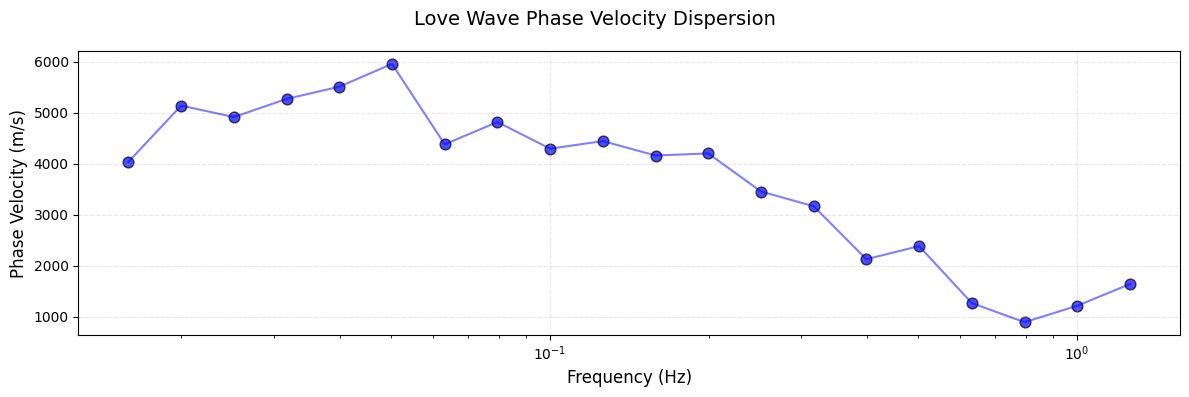

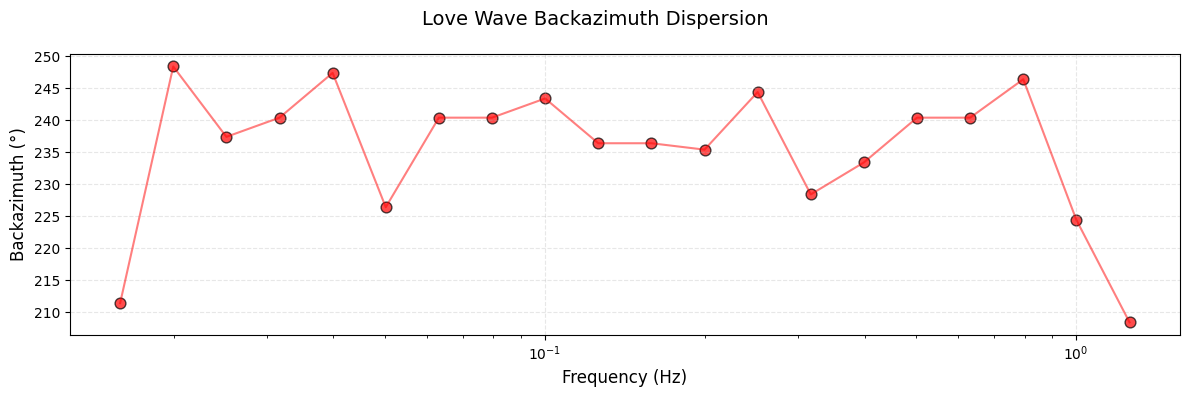

In [18]:
# Plot velocity dispersion
fig_vel = plot_dispersion(disp_love_opt, plot_type='velocity', wave_type='Love')

# Plot backazimuth dispersion
fig_baz = plot_dispersion(disp_love_opt, plot_type='backazimuth', wave_type='Love')

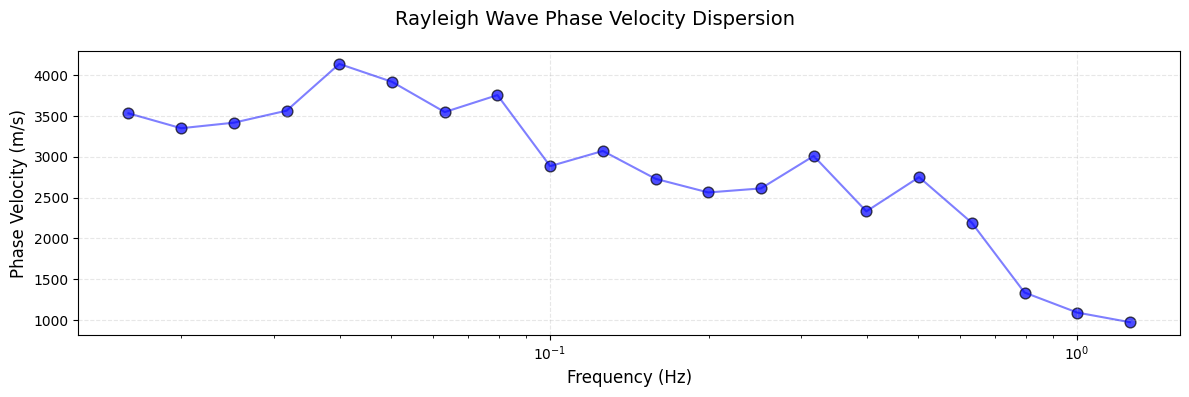

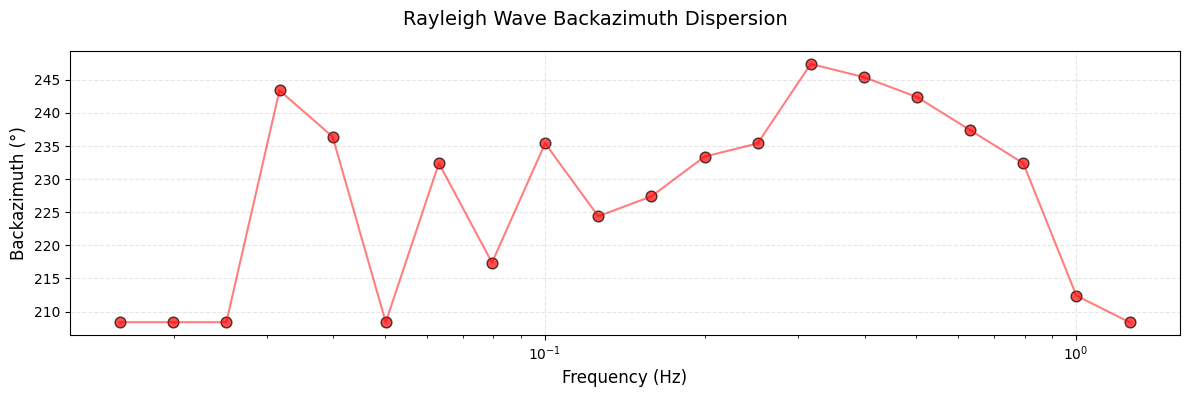

In [19]:
# Plot velocity dispersion
fig_vel = plot_dispersion(disp_rayleigh_opt, plot_type='velocity', wave_type='rayleigh')

# Plot backazimuth dispersion
fig_baz = plot_dispersion(disp_rayleigh_opt, plot_type='backazimuth', wave_type='rayleigh')

## Comparison of optimized and non-optimized dispersion curves

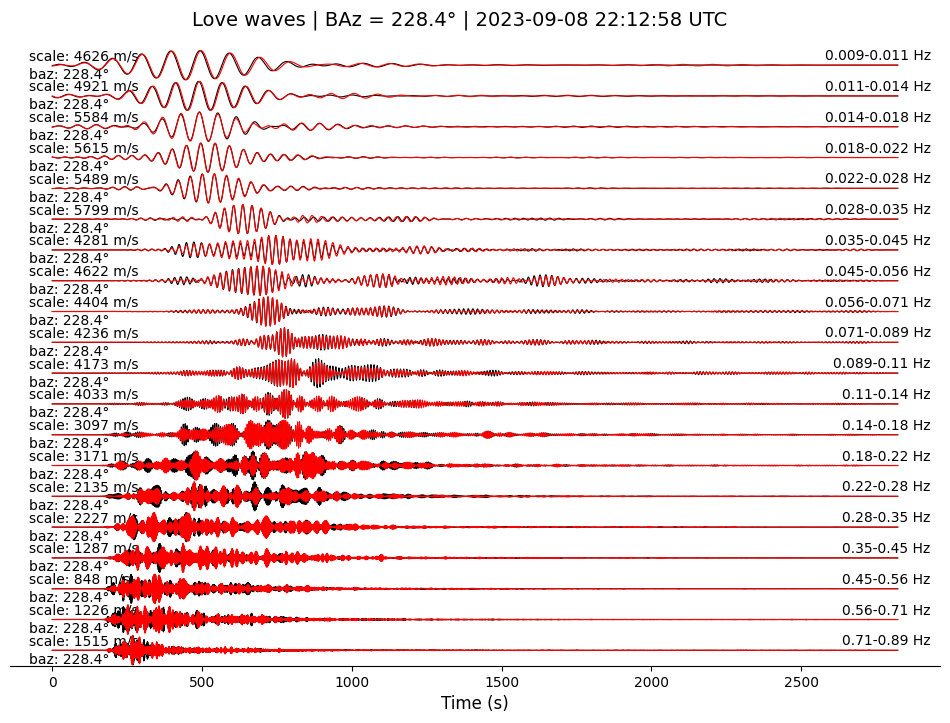

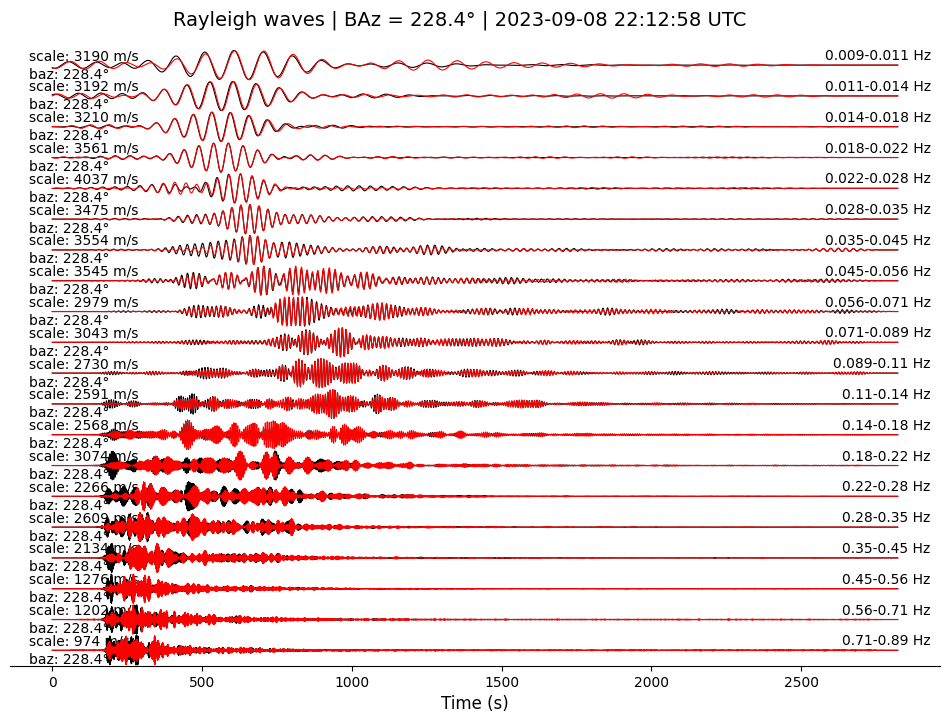

In [20]:
fig, disp_love = plot_trace_dispersion(
    sd_object=sd,
    wave_type="Love",
    fmin=0.01,
    fmax=0.8,
    fraction_of_octave=3,
    baz=ev['backazimuth'],
    figsize=(12, 8),
    optimized=False,
    output=True
)

fig, disp_rayleigh = plot_trace_dispersion(
    sd_object=sd,
    wave_type="Rayleigh",
    fmin=0.01,
    fmax=0.8,
    fraction_of_octave=3,
    baz=ev['backazimuth'],
    figsize=(12, 8),
    optimized=False,
    output=True
)


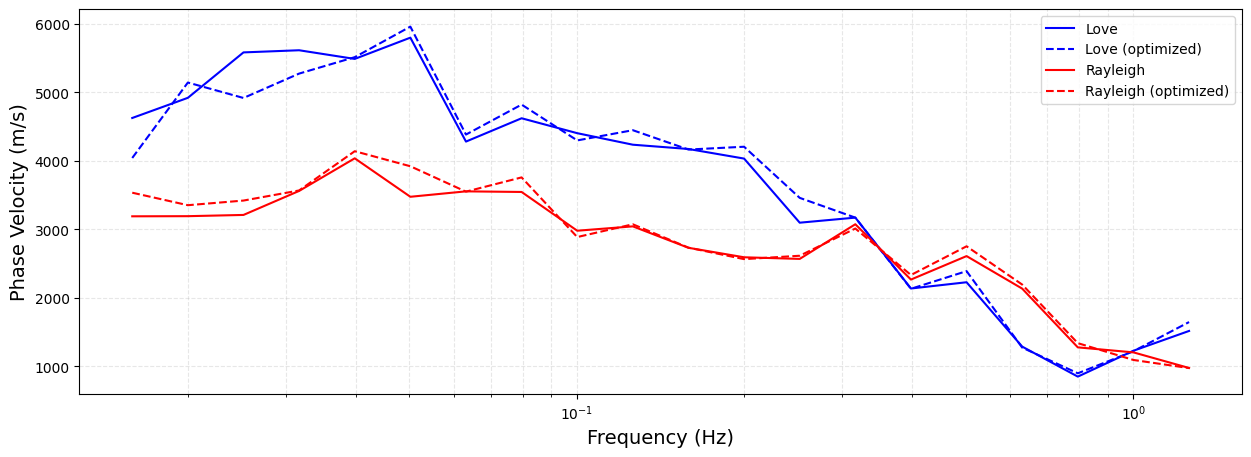

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.plot(disp_love['frequencies'], disp_love['velocities'], label='Love', color='blue')
ax.plot(disp_love_opt['frequencies'], disp_love_opt['velocities'], label='Love (optimized)', color='blue', linestyle='--')

ax.plot(disp_rayleigh['frequencies'], disp_rayleigh['velocities'], label='Rayleigh', color='red')
ax.plot(disp_rayleigh_opt['frequencies'], disp_rayleigh_opt['velocities'], label='Rayleigh (optimized)', color='red', linestyle='--')

ax.set_xscale('log')
ax.set_ylabel('Phase Velocity (m/s)', fontsize=14)
ax.set_xlabel('Frequency (Hz)', fontsize=14)
ax.grid(which='both', alpha=0.3, linestyle='--')
ax.legend(loc=1)


### Test optimization of parameters with frequency and backazimuth in time windows

For Love waves:

In [ ]:
# # Get optimization results
# params = sd.optimize_parameters(
#     wave_type='love', 
#     fbands={'fmin': 0.01, 'fmax': 0.2, 'octave_fraction': 6}, 
#     baz_step=config['baz_step'],
#     twin_min=config['twin_sec'],
#     overlap=0.5,
#     bandwidth_factor=6
# )

# # Plot results using the class method
# fig = sd.plot_optimization_results(
#     params, wave_type='love',
#     vel_max_threshold=5000,
#     cc_threshold=config['cc_threshold'],
#     baz_theo=ev['backazimuth']
# )


For Rayleigh waves:

In [ ]:
# # Get optimization results
# params = sd.optimize_parameters(
#     wave_type='rayleigh', 
#     fbands={'fmin': 0.01, 'fmax': 0.2, 'octave_fraction': 6}, 
#     baz_step=config['baz_step'],
#     twin_min=config['twin_sec'],
#     overlap=0.5,
#     bandwidth_factor=6
# )

# # Plot results using the class method
# fig = sd.plot_optimization_results(
#     params, wave_type='rayleigh',
#     vel_max_threshold=5000,
#     cc_threshold=config['cc_threshold'],
#     baz_theo=ev['backazimuth']
# )
